In [7]:
import pandas as pd
import os

# List files in dataset\processed_data

files = os.listdir('dataset/processed_data')
print(files)

# Read the files into a dataframe
for idx, file in enumerate(files):
    if idx == 0:
        df = pd.read_csv('dataset/processed_data/' + file, na_values=['', ' ', 'No information found.'])
    else:
        df = pd.concat([df, pd.read_csv('dataset/processed_data/' + file, na_values=['', ' ', 'No information found.'])], ignore_index=True)

['10_MPlus_ADAM_QA.csv', '11_MPlusDrugs_QA.csv', '12_MPlusHerbsSupplements_QA.csv', '1_CancerGov_QA.csv', '2_GARD_QA.csv', '3_GHR_QA.csv', '4_MPlus_Health_Topics_QA.csv', '5_NIDDK_QA.csv', '6_NINDS_QA.csv', '7_SeniorHealth_QA.csv', '8_NHLBI_QA_XML.csv', '9_CDC_QA.csv']


In [8]:
# Quedarse con las filas sin nan
df = df.dropna()
# Quedarse con las 300 primeras filas
# df = df.head(100)

df

,question,question_id,question_type,answer
0,What is (are) A guide to clinical trials for c...,0000001-1,information,"If you have cancer, a clinical trial may be an..."
5,Do you have information about A guide to herba...,0000002-1,information,Herbal remedies are plants used like a medicin...
6,What is (are) A1C test ?,0000003-1,information,A1C is a lab test that shows the average level...
8,What is (are) Aarskog syndrome ?,0000004-1,information,Aarskog syndrome is a very rare disease that a...
9,What causes Aarskog syndrome ?,0000004-2,causes,Aarskog syndrome is a genetic disorder that is...
...,...,...,...,...
47242,What is (are) Parasites - Zoonotic Hookworm ?,0000440-1,information,"There are many different species of hookworms,..."
47243,Who is at risk for Parasites - Zoonotic Hookwo...,0000440-2,susceptibility,Dog and cat hookworms are found throughout the...
47244,How to diagnose Parasites - Zoonotic Hookworm ?,0000440-5,exams and tests,Cutaneous larva migrans (CLM) is a clinical di...
47245,What are the treatments for Parasites - Zoonot...,0000440-6,treatment,The zoonotic hookworm larvae that cause cutane...


<Axes: >

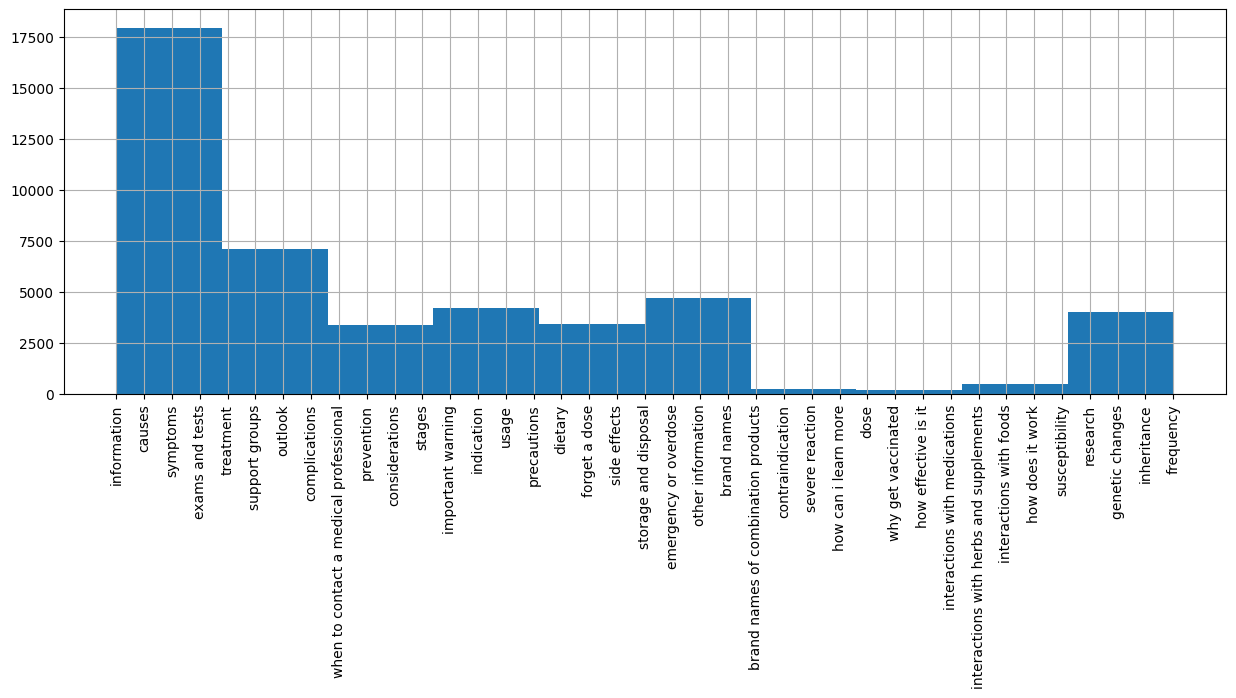

In [9]:
# Mostrar histograma de question_type para ver cuantos tipos de preguntas hay con etiquetas verticales

df.question_type.hist(figsize=(15,5), xrot=90)


In [10]:
import faiss
from faiss import write_index
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

# Movemos el modelo y los datos al dispositivo que corresponda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Función para obtener word embeddings con BERT
def get_bert_embeddings(documents):
  tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
  model = AutoModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT').to(device)
  embeddings = []
  for doc in documents:
    inputs = tokenizer(doc, return_tensors='pt', truncation=True, padding=True, max_length=256).to(device)
    with torch.no_grad():
      outputs = model(**inputs)
    doc_embedding = outputs.last_hidden_state.mean(1).squeeze().cpu().numpy()
    embeddings.append(doc_embedding)
  return np.array(embeddings)

# Función para crear el índice FAISS
def create_faiss_index(embeddings):
  dimension = embeddings.shape[1]
  index = faiss.IndexFlatL2(dimension)
  index.add(embeddings)
  return index


documents = df.question.tolist()  # Los textos están en la columna "title"
print(documents)
# Procesamos los documentos para obtener los word embeddings
embeddings = get_bert_embeddings(documents)

# Crea el índice FAISS con los embeddings
index = create_faiss_index(embeddings)

['What is (are) A guide to clinical trials for cancer ?', 'Do you have information about A guide to herbal remedies', 'What is (are) A1C test ?', 'What is (are) Aarskog syndrome ?', 'What causes Aarskog syndrome ?', 'What are the symptoms of Aarskog syndrome ?', 'How to diagnose Aarskog syndrome ?', 'What are the treatments for Aarskog syndrome ?', 'Where to find support for people with Aarskog syndrome ?', 'What is the outlook for Aarskog syndrome ?', 'What are the complications of Aarskog syndrome ?', 'Do I need to see a doctor for Aarskog syndrome ?', 'How to prevent Aarskog syndrome ?', 'What is (are) Aase syndrome ?', 'What causes Aase syndrome ?', 'What are the symptoms of Aase syndrome ?', 'How to diagnose Aase syndrome ?', 'What are the treatments for Aase syndrome ?', 'What is the outlook for Aase syndrome ?', 'What are the complications of Aase syndrome ?', 'How to prevent Aase syndrome ?', 'Do you have information about Abdomen - swollen', 'What is (are) Abdominal aortic ane

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
# Función para obtener los embeddings de una consulta de texto
def get_query_embedding(query_text):
    tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
    model = AutoModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT').to(device)
    inputs = tokenizer(query_text, return_tensors='pt', truncation=True, padding=True, max_length=256).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    query_embedding = outputs.last_hidden_state.mean(1).squeeze().cpu().numpy()
    return query_embedding

# Ejemplo de consulta
query_text = "Do I need to see a doctor for Abdominal mass ?"
query_embedding = get_query_embedding(query_text)
query_vector = np.expand_dims(query_embedding, axis=0)
print(f'Query vector: {query_vector}')
# Realiza la búsqueda en el índice FAISS
D, I = index.search(query_vector, k=5)  # Busca los 5 documentos más similares

print("Consulta realizada con el texto:", query_text)
print("Documentos más similares:")
for i, idx in enumerate(I[0], start=1):
    print(f"{i}: Documento {idx} con una distancia de {D[0][i-1]}")
    print("Contenido del documento:", documents[idx])

Query vector: [[ 3.91301095e-01 -2.04428919e-02 -3.68257314e-01  2.00264022e-01
  -3.78240533e-02  2.34661996e-01  4.12874997e-01  1.26883209e-01
  -6.02498613e-02 -2.16344938e-01  1.58081755e-01  2.41391003e-01
  -2.12859422e-01  5.09885192e-01 -4.93279755e-01 -2.07748234e-01
   6.30637109e-02 -2.14361489e-01 -1.23459967e-02 -6.60514832e-02
  -4.40270364e-01  2.74791628e-01 -1.43249586e-01 -3.79597813e-01
  -2.32705157e-02 -4.66047823e-01  1.37873754e-01  7.60122180e-01
   1.48143157e-01  2.53658056e-01  1.42181039e-01 -1.14118613e-01
   5.96977733e-02  1.06353171e-01 -1.19724004e-02  4.27794427e-01
   5.00064269e-02  2.59515941e-01 -1.19257085e-01  1.11834802e-01
   8.16896483e-02  7.31953559e-03  3.32867861e-01  3.56928259e-01
   2.45251283e-01  1.23453289e-01  9.76206958e-02 -1.79099396e-01
  -7.87053943e-01  1.55757800e-01  2.86830723e-01  2.47016728e-01
   3.22545826e-01  2.05549613e-01  3.20427328e-01  6.81505576e-02
  -3.26821297e-01 -1.40798464e-01 -1.01556808e-01  4.02768224e